Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 03: Analysis of behavioural data

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 7, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this exercise sheet we will start to work on a real dataset from an ongoing experiment. In this experiment the participants were asked to freely explore an unknown virtual city, called Seahaven, with an interactive map. After a sufficiently long exploration the participants were tested on three different tasks: 

- the **absolute orientation** of a single house towards the north cardinal direction
- the **relative orientation** between two houses 
- **pointing** from the location of one house to the other

Each task type was performed in two time conditions:

- **3 seconds** for spontaneous decisions
- **infinite** response time for cognitive reasoning

These measurements were repeated up to three times on different days.

We will provide you with more detailed information about this experiment in the tutorial. If you are interested in more than this feel free to have a look at the paper https://www.biorxiv.org/content/10.1101/539080v1.

A small side remark to the dataset: The RTs for the absolute task are exactly the same for both time conditions. This is an error that cannot be corrected on a short notice. Please keep that in mind, when you evaluate your plots.

## Assignment 0: Peer review for sheet 02 [3 pts]

Open an issue in the repository of the groups you have to check. The title of the issue should be your group name (e.g. "Group1). Comment on what was good and what was bad, the aesthetics and ease of reading the plots, what you would have done differently and how many points you would give them for their solutions.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 11, 9 | 5, 1  | 8, 2  | 2, 7 | 10, 6 | 7, 11 | 6, 5  | 4, 3  | 3, 8  | 1, 4   | 9, 10  |

## Assignment 1: Preprocessing [3 pts]

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from copy import deepcopy
import itertools

### a) Preprocessing the data [1 pt]

First of all you should preprocess the data. This is an important step to avoid running into any problems when you start to analyse the data. Since we provide the Seahaven dataset as an excel file make sure to run ```pip install xlrd``` in your activated acc environment beforehand. This allows you to directly read from excel files.

- Import the data of all three tasks (Absolute, Relative, Pointing) into one dataframe. Since we don't need the whole data, load only the columns "ReactionTime", "AngularDiffBin", "Subject", "Task", "Time", "Answer" and "Measurement".
- Clean the dataframe of all NaNs, i.e. remove all rows where at least one element is missing. How many rows have been removed?
- Change the values of the column "Answer". Replace each value "wrong" with 0 and each value "correct" with 1.

In [2]:
def load_data(path: str, filter_outlier: bool = False) -> pd.DataFrame:
    """
    Load the Seaheaven data from an Excel file.
    """
    
    # Load the Excel file and extract DataFrames
    excel_data = pd.ExcelFile(path)
    excel_sheets = [excel_data.parse(sheet) for sheet in excel_data.sheet_names]
    
    # Create a single DataFrame
    data = pd.concat(excel_sheets, ignore_index=True, sort=False)
    
    # Filter for columns of interest
    data = data[["ReactionTime", "AngularDiffBin", "Subject", "Task", "Time", "Answer", "Measurement"]]
    
    # Drop NaNs
    data_nonan = data.dropna(axis=0, how="any")
    print("Removed {} nans.".format(len(data) - len(data_nonan)))

    # Convert Answer to numeric
    data_nonan.loc[: ,'Answer'] = data_nonan['Answer'].apply(lambda x: 0 if x == "wrong" else 1)
        
    return data_nonan

data = load_data("Seahaven_dataset.xlsx")



Removed 1301 nans.


c:\users\sarah\anaconda3\envs\acc\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### b) Checking the distribution of the data [2 pts]

Most of the analysis techniques require normally distributed data. To get an idea on how the data looks like use the **preprocessed data** from 1.a) and plot for each task a violinplot that displays the data distribution of the RTs (note that you also have to distinguish between the two time conditions - 3sec and Infinite).

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the mean RT per subject.
- Make a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- Hint: Play with the keyword inner.
- Using your plots, what can you say about the distribution of the data? It is normally distributed? How is it skewed?

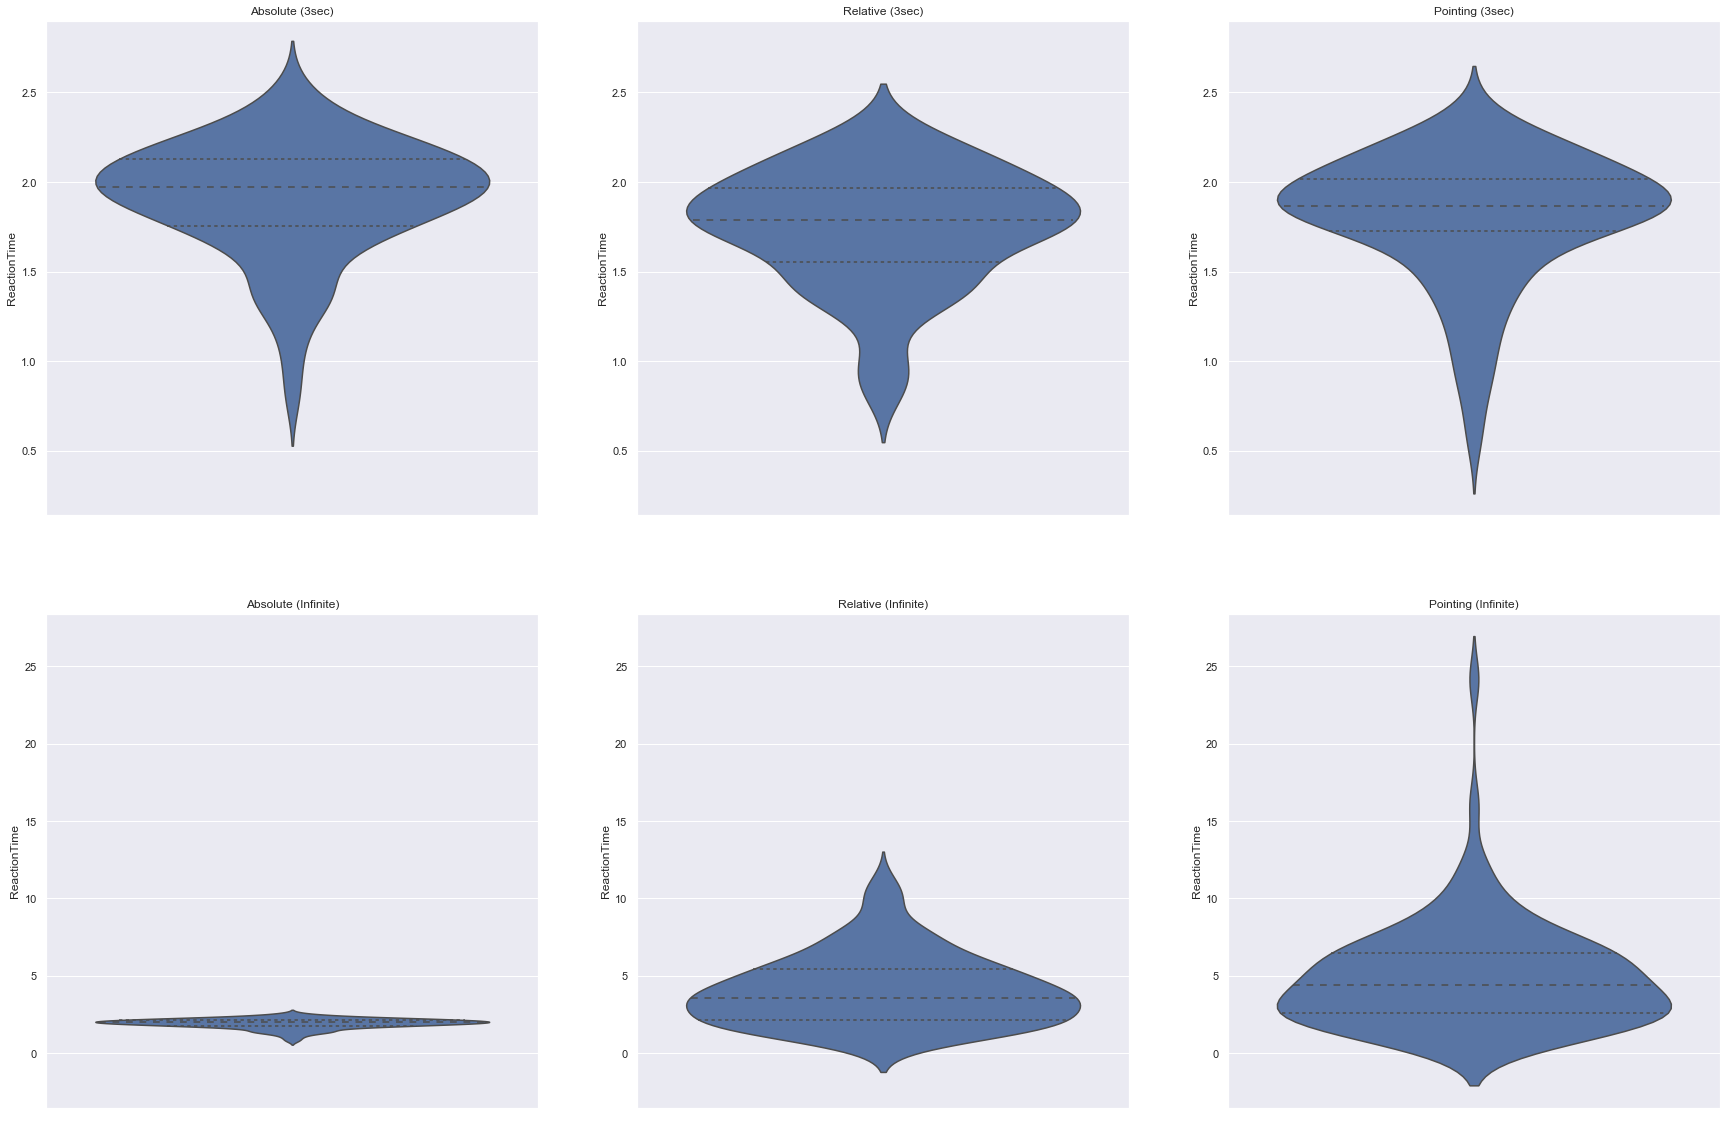

In [3]:
def get_reaction_time(data: pd.DataFrame, task: str, time: str, modifier = None, ang= False) -> pd.DataFrame:
    """
    Extract the reaction times of a specific task and time and filter it optionally with a modifier.
    """
    
    # Select the data
    selection = data[(data["Task"] == task) & (data["Time"] == time)]
    
    # Calculate the data
    if ang:
        selection = selection.groupby(['Subject', 'AngularDiffBin']).mean().reset_index("AngularDiffBin")
    else:    
        selection = selection.groupby('Subject').mean()
    
    
    # Filter the data optionally
    if modifier is not None:
        selection = modifier(selection)
    
    return selection

def plot_data(data: pd.DataFrame, modifier = None) -> None:
    """
    Plot the reaction times for comparisons after optionally filtering them with a modifier. 
    """
    
    # Get the available tasks and times
    tasks = data['Task'].unique()
    times = data['Time'].unique()

    # Create the graph
    figs, axes = plt.subplots(nrows=len(times), ncols=len(tasks), figsize=(30,20))
    
    # Fill the graph
    for task_index, task in enumerate(tasks):
         for time_index, time in enumerate(times):
            # Get the actual data
            selection = get_reaction_time(data, task, time, modifier)
        
            
            # Plot it
            part = axes[time_index, task_index]
            sns.violinplot(y="ReactionTime", data=selection, inner='quartile', ax=part)
            part.set_title("{} ({})".format(task, time))

    # Adjust the graphs per row, that they are all in the range of the smallest and biggest data points
    for row in axes:
        low, upper = zip(*[column.get_ylim() for column in row])
        for column in row:
            column.set_ylim(min(low), max(upper))
        
plot_data(data)

Even if the classical bell shape of a normal distibution is at least partially visible in most of the graphs, the distibutions often to be skewed. Due to negative (i.e. Pointing, 3sec) and positive outliers (i.e. Pointing,  infinite), the graphs are streched. In general, the mean of the reaction time in the setup without the time limit are higher in comparison to the limited-time approach.

You may have noticed that there are (extreme) outliers, that have to be removed from the **preprocessed data**.

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) look at the RTs and keep only the ones that are within +2 and -2 standard deviation:

$ |(RT_{group1} - mean(RT_{group1}))| \leq (2*std(RT_{group1})) $

$group1$ = e.g. data of absolute task for time condition 3sec

- Make again a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- How does the distribution of the data look now? Is it still skewed?

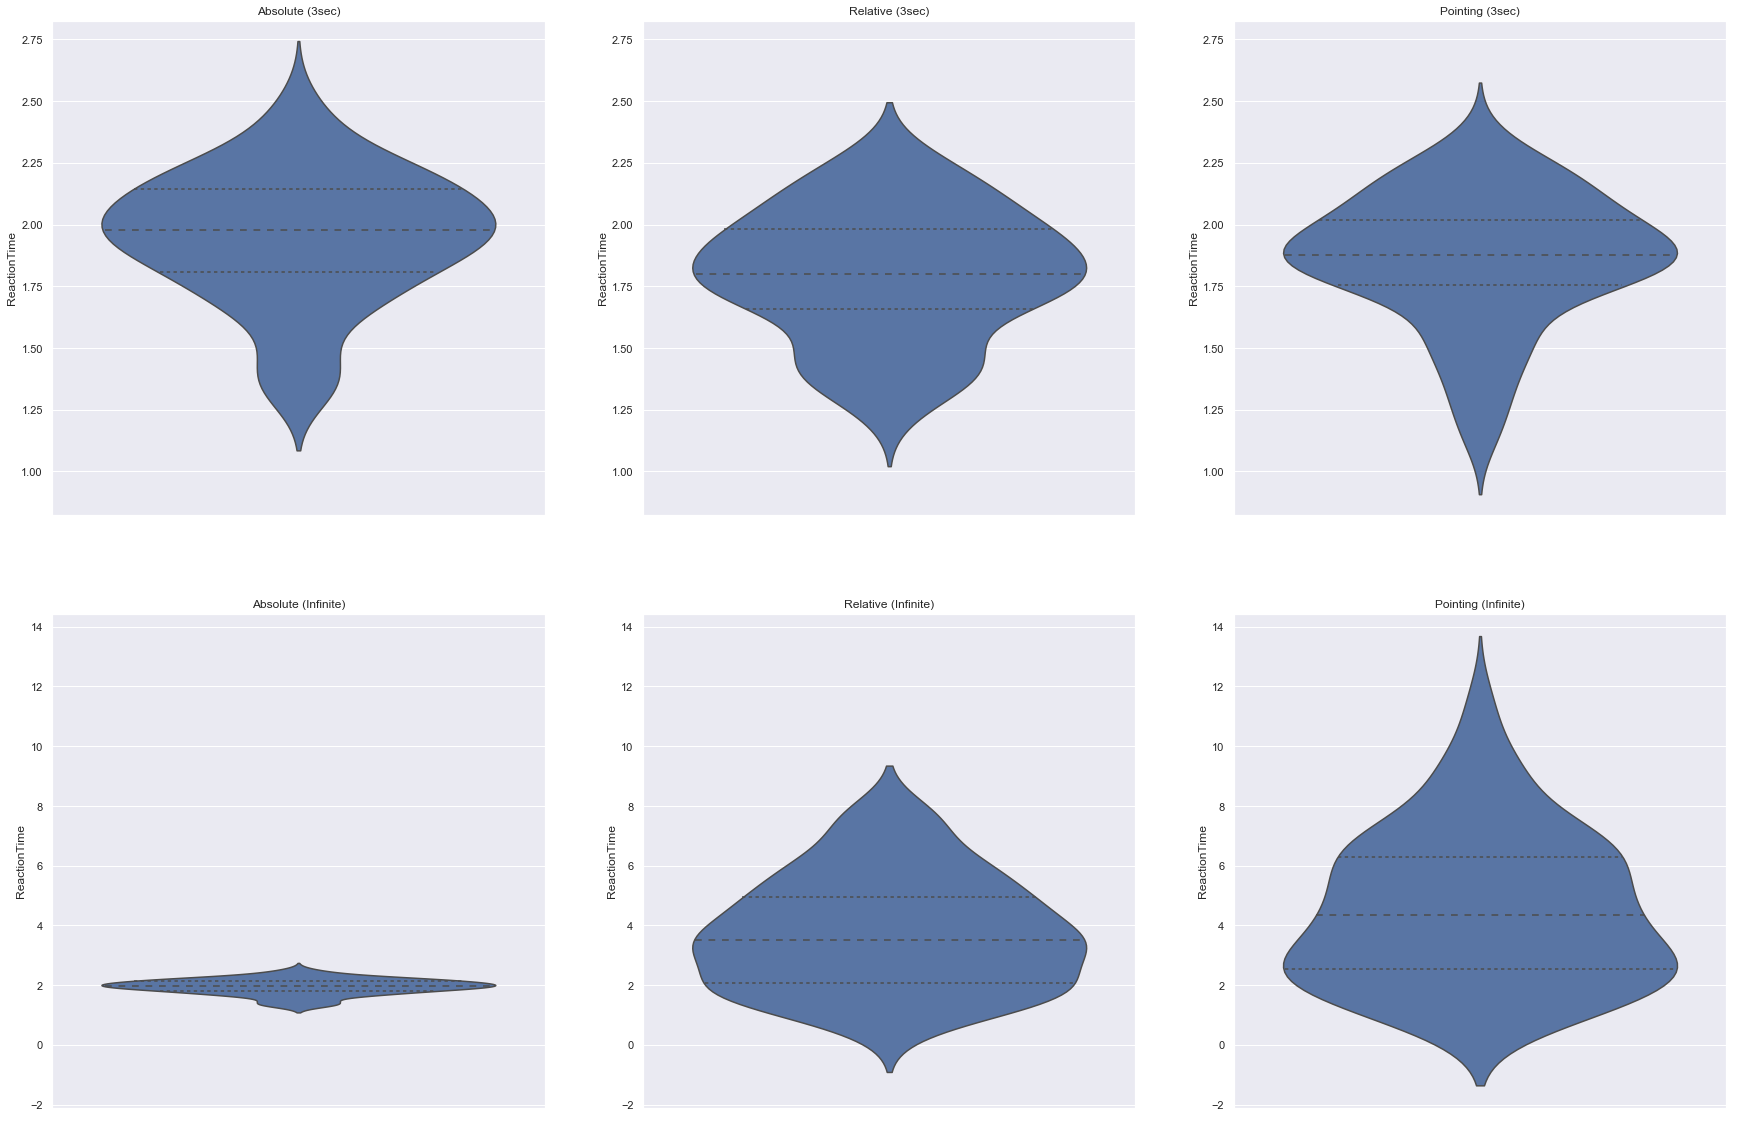

In [4]:
def filter_outlier(data: pd.DataFrame) -> pd.DataFrame:
    # Create a boolean masks for which the absolute standart deviation is within 2
    mask = np.abs(stats.zscore(data['ReactionTime'])) < 2
    return data[mask]

plot_data(data, modifier=filter_outlier)

After the removal of outlier the interpretation of the distibution gets easier. Due to the other stretching, especially the non-normal shape of the distibutions especially in tbe "infinite time" setup gets more obvious.

**Please make sure that you use the preprocessed data without outliers for the following assignments!**

## Assignment 2: Checking for possible hypotheses [5 pts]

### a) Hypothesis 1 [2 pt]

**Hypothesis 1:** "Given that subjects are limited by time, if they are faster in RT they are also less accurate."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a scatterplot of the mean RT (x-axis) and the accuracy (y-axis) for the time condition "3sec". 
- Make a second scatterplot and add a simple linear regression line to it. Calculate the slope of the regression line (you are allowed to use scipy). 
- Considering your results, what can you say about the hypothesis?

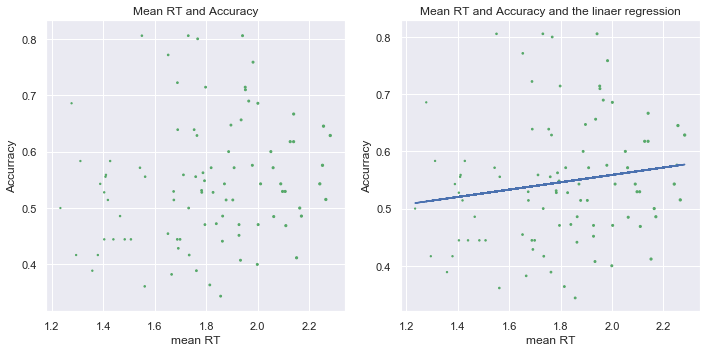

In [5]:
def plot_data_scatter(data, modifier = None):
    "Plot the reaction times for the Relative Task to test the hypothesis 1 with filter data"
    
    #Get the avaliable times and the task "Relative"
    times = data['Time'].unique()
    task = "Relative"
    
    #Create ths graph
    fig, axes = plt.subplots(ncols = 2, figsize = (10,5))

    #Changes the column Answer to Accuracy
    data_renamend = data
    data_renamend = data_renamend.rename(index = str, columns = {"Answer": "Accuracy"})
    
    #Fill the graph)
    for time in times:
            #Gets the selected data 
           
            selection =  get_reaction_time(data_renamend, task, time, modifier)
            
            # Select the data for plotting
            if time == "3sec":
                    
                #Intialzi x and y for plotting
                x = selection["ReactionTime"]
                y = selection["Accuracy"]
                
                #Calculates the linear regression
                slope, intercept, r_value, p_value, std_err  = stats.linregress(x, y)
                
                #plots the first scatterplot
                axes[0].set(xlabel = "mean RT", yLabel = "Accurracy", title = "Mean RT and Accuracy" )
                axes[0].scatter(x, y, s = (x)**2, c = 'g')
                
                #plots the second scatterplot
                axes[1].plot(x, intercept + slope*x)
                axes[1].scatter (x, y, s = (x)**2, c = 'g')
                axes[1].set(xlabel = "mean RT", yLabel = "Accurracy", title = "Mean RT and Accuracy and the linaer regression")
                fig.tight_layout()
            
plot_data_scatter(data, modifier = filter_outlier)

The linear regression shows that the subjects are more accurracy, if the have a higer mean of RT. So the the hypothesis likely to be true

### b) Hypothesis 2 [1 pt]

**Hypothesis 2:** "Given that subjects have infinite time, they perform better."

- Use the data of all three tasks.
- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the tasks (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Considering your plots, what can you say about the hypothesis?

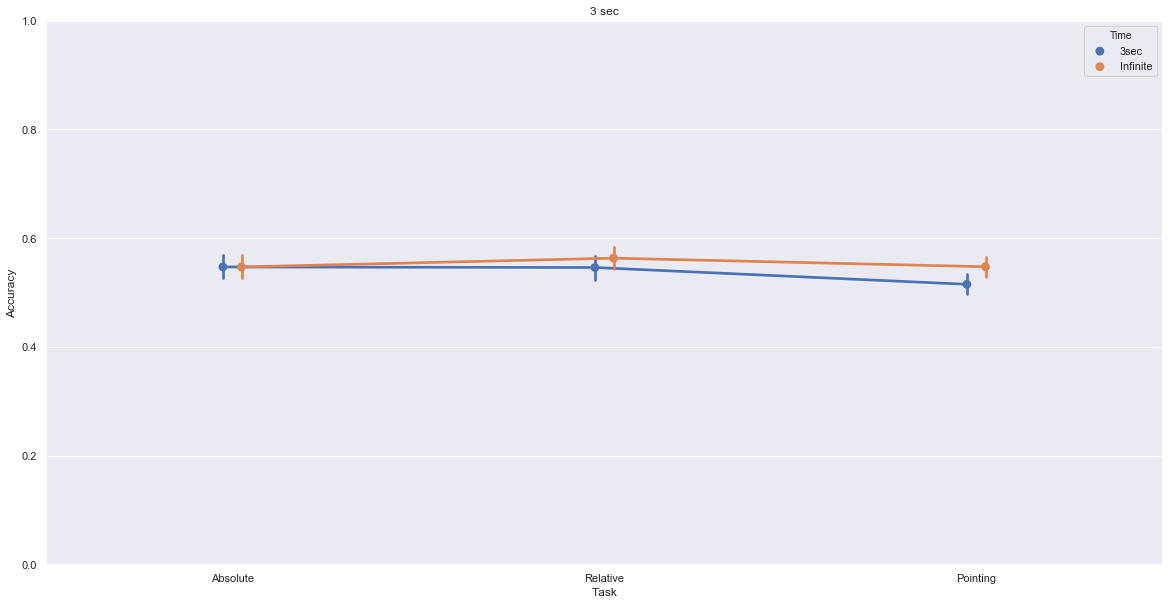

In [33]:
def plot_data_renamend (data: pd.DataFrame, tasks: str, times: str, modifier = None, ang= False) -> pd.DataFrame:
    #Changes the column Answer to Accuracy
    data_renamend = data.rename(index=str, columns={"Answer": "Accuracy"})
    
    #make a empty list to save the concat calculated data
    test = []
    
    # Fill the graph
    for time in times:
        for task in tasks:
            # Get the actual data
            selection = get_reaction_time(data_renamend, task, time, modifier, ang)

            #insert task and time in the actual data for the plot 
            selection.insert(0, "Task", task)
            selection.insert(0, "Time", time)

            #append the actual data in the empty list for saving to plot
            test.append(selection)
            
    
    #concat the list to a dataframe for plotting and returns the data 
    data_plot = pd.concat(test, axis = 0)
    return data_plot


def plot_data_point(data: pd.DataFrame, modifier) -> pd.DataFrame:
    'Plots the data for both timecondintion for the mean accuracy and the different task for comperasion'
    
    # Get the available tasks and times
    tasks = data['Task'].unique()
    times = data['Time'].unique()


    # Create the graph
    figs, axes = plt.subplots(figsize=(20,10))
    
    #get the calculated data for plotting 
    data_plot =plot_data_renamend (data, tasks, times, modifier) 
    
    #plots the data in a pointplot
    axes.set(xlabel = "Task", yLabel = "Accurracy", title = "3 sec")
    #sets the limit for the y-axis
    axes.set_ylim(0,1)
    sns.pointplot( x = "Task",  y = "Accuracy" , data = data_plot, dodge = True, hue = "Time")
    


        
plot_data_point(data, modifier = filter_outlier)
    

### d) Hypothesis 3 [1 pt]

**Hypothesis 3:** "With each subsequent session subjects get better in performance."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the measurement (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Make also a pointplot of the measurement (x-axis) and RT (y-axis) for both time conditions (3sec / Infinite).  Make sure that the data is displayed clearly. You may split up the single plots for a better overview.
- Considering your plots, what can you say about the hypothesis?

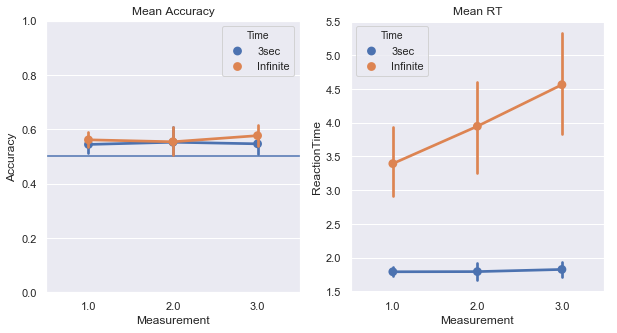

In [34]:
def plot_data_measurement(data, modifier = None):
    "Plot the reaction times for the Relative Task to test the hypothesis 1 with filter data"
    palette = itertools.cycle(["r","b","g","y"])

    #Get the avaliable times and the task "Relative"
    times = data['Time'].unique()
    task = ["Relative"]
    
    #Create ths graph
    fig, axes = plt.subplots(ncols=2, figsize= (10,5))
    
    #get the calculated data for plotting 
    data_plot = plot_data_renamend (data, task, times, modifier) 
    

    #plots the first pointplot
    axes[0].axhline(0.5)
    axes[0].set(xlabel = "Measurement", yLabel = "Accurracy", title = "Mean Accuracy")
    sns.pointplot(x = "Measurement", y = "Accuracy" , data = data_plot, ax = axes[0], hue = 'Time')
    
    # Adjust the graphs per column, that they are all in the range of 0 to 1
    axes[0].set_ylim(0, 1)

    #plots the second pointplot
    axes[1].set(xlabel = "Measurement", yLabel = "ReactionTime", title = "Mean RT")
    sns.pointplot(x = "Measurement", y = "ReactionTime" , data = data_plot, inner='quartile', ax = axes[1], hue = 'Time')

          
    
plot_data_measurement(data, modifier = filter_outlier)

The output does not clearly verify the hypothesis since there is only a tiny increase in accuracy with repeated measurements.

### c) Hypothesis 4 [1 pts]

**Hypothesis 4:** "When the angular difference between houses increases subjects are more accurate in the relative task."

- Use the data of the relative task.
- For each angular difference (see "AngularDiffBin") calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the angular differences (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance. Make sure that the angular differences are displayed in ascending order.
- Hint: Play with the keyword dodge.
- Considering your plots, what can you say about the hypothesis?

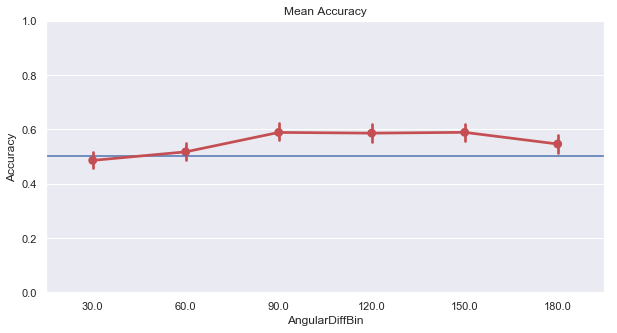

In [41]:
def plot_data_measurement(data, modifier = None):
    "Plot the reaction times for the Relative Task to test the hypothesis 1 with filter data"

    #Get the avaliable times and the task "Relative"
    times = data['Time'].unique()
    task = ["Relative"]
    
    #Create ths graph
    fig, axes = plt.subplots(figsize= (10,5))

    #get the calculated data for plotting 
    selection = plot_data_renamend (data, task, times, modifier, ang = True) 

            
    #plots the first pointplot
    axes.axhline(0.5)
    axes.set(xlabel = "AngularDiffBin", yLabel = "Accurracy", title = "Mean Accuracy")
    sns.pointplot(x = "AngularDiffBin", y = "Accuracy" , data = selection, color = "r")
    # Adjust the graphs per column, that they are all in the range of 0 to 1
    axes.set_ylim(0, 1)
                
            
            
plot_data_measurement(data, modifier = filter_outlier)

## Assignment 3: T-test [2 pts]

We will perform a two-sample t-test, i.e. we compare the mean of two groups under the assumption that both are independent and normally distributed with unknown but equal variances. In this case we will look at the data of the relative task and compare the accuracies of the two time conditions (3sec / Infinte). We will ignore that there are different measurement days!

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Check if the data is normally distributed using scipy.stats.normaltest.


- Compute the t-statistics: $ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $

$\bar{x}_1$: mean accuracy of all subjects for time condition "3sec" <br>
$\bar{x}_2$: mean accuracy of all subjects for time condition "Infinite" <br>
$n_1$: sample size for time condition "3sec" <br>
$n_2$: sample size for time condition "Infinite"


- with $ s^2 = \frac{\sum_{i=1}^n{(x_i - \bar{x})^2}}{n-1} $

$x_i$: accuracy of subject i <br>
$\bar{x}$: mean accuracy of all subjects <br>
$n$: sample size


- Calculate the degrees of freedom: $ df = n_1 + n_2 -2 $
- What does the p-value of a t-test tell you in general? Also explain what your calculated p-value tells you specifically (given $\alpha = 0.05$)?

In [ ]:

#Get the avaliable times and the task "Relative"
times = data['Time'].unique()
task = "Relative"
    
#Changes the column Answer to Accuracy
data_renamend = data
data_renamend = data_renamend.rename(index=str, columns={"Answer": "Accuracy"})
    
    #Fill the graph)
    for time in times:
            
            #Gets the selected data
            
            selection =  get_reaction_time(data_renamend, task, time, modifier)
            scipy.stats.normaltest(a, axis=0, nan_policy='propagate')[source]
            if : 
                print()

# gives you the p-value after comparing the t-statistic with the critical t value (computed internally) 
p = 1 - stats.t.cdf(t,df=df)

print("t = " + str(t))
print("p = " + str(2*p))

# test if your calculation is correct
t2, p2 = stats.ttest_ind(x1,x2)
print("t = " + str(t2))
print("p = " + str(p2))